### Import required libraries

In [27]:
import time
import argparse
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
from utils import load_data, accuracy
from model import GCN
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

### Check data

In [18]:
cite_data = pd.read_csv('/home/ec2-user/SageMaker/graph-cnn.mxnet/data/cora/cora.cites', sep = '\t', header=None)
cite_data.columns = ['cited', 'citing']
cite_data.head()

cited   citing
0     35     1033
1     35   103482
2     35   103515
3     35  1050679
4     35  1103960

In [21]:
content_data = pd.read_csv('/home/ec2-user/SageMaker/graph-cnn.mxnet/data/cora/cora.content', sep = '\t', header=None)
#content_data.columns = ['cited', 'citing']
content_data.head(n=10)

0     1     2     3     4     5     6     7     8     9     \
0    31336     0     0     0     0     0     0     0     0     0   
1  1061127     0     0     0     0     0     0     0     0     0   
2  1106406     0     0     0     0     0     0     0     0     0   
3    13195     0     0     0     0     0     0     0     0     0   
4    37879     0     0     0     0     0     0     0     0     0   
5  1126012     0     0     0     0     0     0     0     0     0   
6  1107140     0     0     0     0     0     0     0     0     0   
7  1102850     0     0     0     1     0     0     0     0     0   
8    31349     0     0     0     0     0     0     0     0     0   
9  1106418     0     0     0     0     0     0     0     0     0   

            ...            1425  1426  1427  1428  1429  1430  1431  1432  \
0           ...               0     0     1     0     0     0     0     0   
1           ...               0     1     0     0     0     0     0     0   
2           ...               0     0     0     0     0     0     0     0   
3           ...               0     0     0     0     0     0     0     0   
4           ...               0     0     0     0     0     0     0     0   
5           ...               0     0     1     0     0     0     0     0   
6           ...               0     0     0     0     0     0     0     0   
7           ...               0     0     0     0     0     0     0     0   
8           ...               0     0     0     0     0     0     0     0   
9           ...               0     0     0     0     0     0     0     0   

   1433                    1434  
0     0         Neural_Networks  
1     0           Rule_Learning  
2     0  Reinforcement_Learning  
3     0  Reinforcement_Learning  
4     0   Probabilistic_Methods  
5     0   Probabilistic_Methods  
6     0                  Theory  
7     0         Neural_Networks  
8     0         Neural_Networks  
9     0                  Theory  

[10 rows x 1435 columns]

In [40]:
# encode class labels 
cls_labels = dict()
for i, c in enumerate(set(content_data.ix[:,1434].tolist())):
    cls_labels[c] = i
    
cls_labels

{'Reinforcement_Learning': 0,
 'Theory': 1,
 'Case_Based': 2,
 'Probabilistic_Methods': 3,
 'Genetic_Algorithms': 4,
 'Neural_Networks': 5,
 'Rule_Learning': 6}

### Create and visualize the network

In [23]:
G = nx.from_pandas_edgelist(cite_data, source='citing', target='cited',  create_using=nx.DiGraph())
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 2708
Number of edges: 5429
Average in degree:   2.0048
Average out degree:   2.0048


In [53]:
# calculate node positions for visualization
pos = nx.spring_layout(G, iterations=100)

In [51]:
# color coding nodes based on their classes
node_color = [cls_labels[content_data.ix[content_data.ix[:,0]==node,1434].tolist()[0]] for node in G.nodes()]

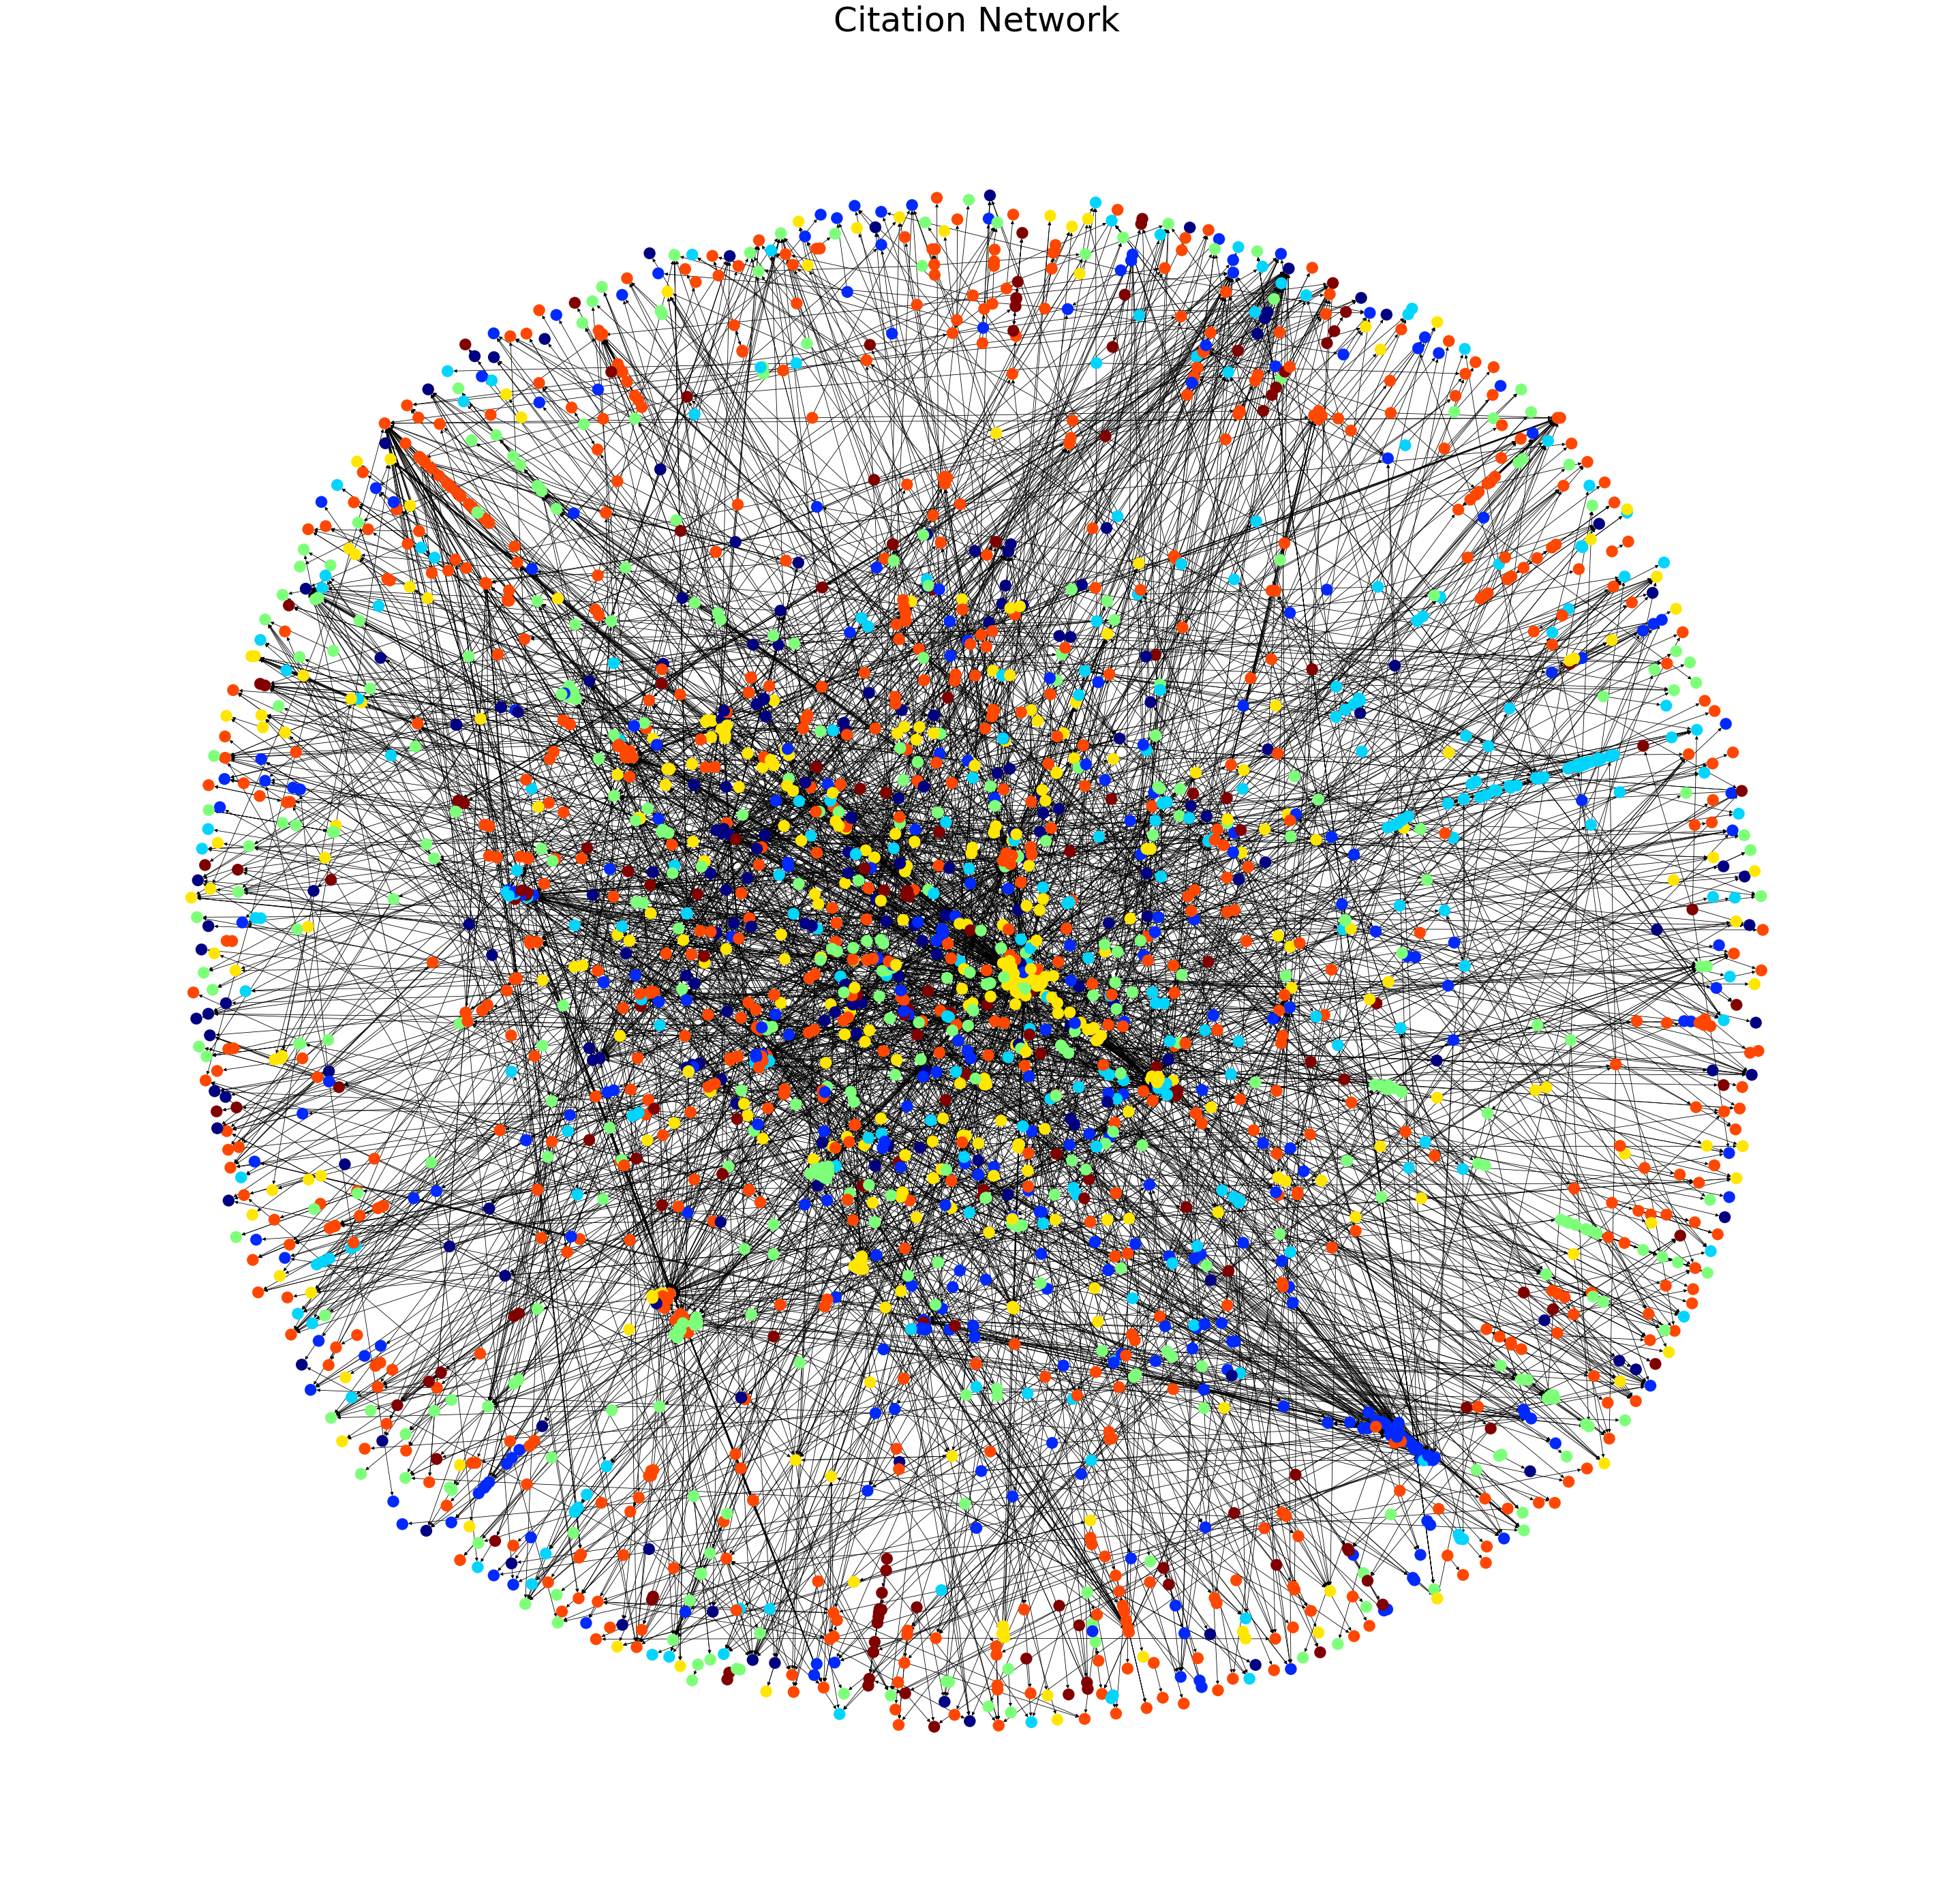

In [54]:
plt.figure(figsize=(50,50))
plt.axis("off")
plt.title('Citation Network', fontsize=50)
nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap("jet"), node_color = node_color, with_labels = False, width = 0.8, linewidths=0.1)
plt.show()

### Set up context

In [2]:
ctx = mx.gpu(0) 

### Hyperparameters

In [6]:
lr = 0.01
seed = 42
dropout = 0.0
hidden = 16
epochs = 200
weight_decay = 5e-4
optim = 'adam'
loss = gluon.loss.SoftmaxCrossEntropyLoss() # Original implementation uses Negative Log Likelihood

### Set seed for random number generators in numpy and mxnet

In [7]:
np.random.seed(seed)
mx.random.seed(seed)

adj, features, labels, idx_train, idx_val, idx_test = load_data(ctx=ctx)

model = GCN(nfeat=features.shape[1],
            nhid=hidden,
            nclass=int(labels.max().asnumpy().item()) + 1,
            dropout=dropout)

model.collect_params().initialize(ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr,})

Loading cora dataset...


### Training process

In [8]:
accs = []

for epoch in range(epochs):
    t = time.time()
    with autograd.record():
        output = model(features, adj)
        loss_train = loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        accs.append(acc_train)
        loss_train.backward()

    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(np.mean(loss_train.asnumpy())),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))

    trainer.step(1)

print(
    'Training Accuracy: ', accuracy(output[idx_train], labels[idx_train]), '\n',
    'Validation Accuracy: ', accuracy(output[idx_val], labels[idx_val]), '\n',
    'Test Accuracy: ', accuracy(output[idx_test], labels[idx_test])
)

Epoch: 0001 loss_train: 4.8037 acc_train: 0.0571 time: 0.7131s
Epoch: 0002 loss_train: 4.2639 acc_train: 0.0571 time: 0.2929s
Epoch: 0003 loss_train: 3.8390 acc_train: 0.0571 time: 0.0042s
Epoch: 0004 loss_train: 3.5038 acc_train: 0.0571 time: 0.0042s
Epoch: 0005 loss_train: 3.2162 acc_train: 0.2000 time: 0.0041s
Epoch: 0006 loss_train: 2.9492 acc_train: 0.2000 time: 0.0042s
Epoch: 0007 loss_train: 2.6978 acc_train: 0.2000 time: 0.0041s
Epoch: 0008 loss_train: 2.4729 acc_train: 0.2000 time: 0.0042s
Epoch: 0009 loss_train: 2.2854 acc_train: 0.2000 time: 0.0041s
Epoch: 0010 loss_train: 2.1359 acc_train: 0.2000 time: 0.0043s
Epoch: 0011 loss_train: 2.0226 acc_train: 0.3500 time: 0.0040s
Epoch: 0012 loss_train: 1.9480 acc_train: 0.2929 time: 0.0040s
Epoch: 0013 loss_train: 1.9110 acc_train: 0.2929 time: 0.0040s
Epoch: 0014 loss_train: 1.9006 acc_train: 0.2929 time: 0.0040s
Epoch: 0015 loss_train: 1.8995 acc_train: 0.2929 time: 0.0039s
Epoch: 0016 loss_train: 1.8939 acc_train: 0.2929 time: 

Epoch: 0168 loss_train: 0.3300 acc_train: 0.9714 time: 0.0041s
Epoch: 0169 loss_train: 0.3252 acc_train: 0.9714 time: 0.0037s
Epoch: 0170 loss_train: 0.3205 acc_train: 0.9714 time: 0.0040s
Epoch: 0171 loss_train: 0.3158 acc_train: 0.9714 time: 0.0041s
Epoch: 0172 loss_train: 0.3112 acc_train: 0.9714 time: 0.0045s
Epoch: 0173 loss_train: 0.3068 acc_train: 0.9714 time: 0.0041s
Epoch: 0174 loss_train: 0.3024 acc_train: 0.9714 time: 0.0039s
Epoch: 0175 loss_train: 0.2980 acc_train: 0.9714 time: 0.0041s
Epoch: 0176 loss_train: 0.2938 acc_train: 0.9714 time: 0.0039s
Epoch: 0177 loss_train: 0.2896 acc_train: 0.9714 time: 0.0040s
Epoch: 0178 loss_train: 0.2855 acc_train: 0.9714 time: 0.0039s
Epoch: 0179 loss_train: 0.2815 acc_train: 0.9714 time: 0.0039s
Epoch: 0180 loss_train: 0.2775 acc_train: 0.9714 time: 0.0040s
Epoch: 0181 loss_train: 0.2737 acc_train: 0.9714 time: 0.0040s
Epoch: 0182 loss_train: 0.2698 acc_train: 0.9714 time: 0.0039s
Epoch: 0183 loss_train: 0.2661 acc_train: 0.9714 time: 